# Практическая работа №9: "Распределенная обработка данных с использованием MPI"
Цель работы:
1. Изучить продвинутые операции MPI (передача сообщений, коллективные
операции, односторонняя передача).
2. Реализовать программы для сложной распределённой обработки данных.
3. Исследовать производительность и масштабируемость программ на
кластере.

Задание 1: Распределённое вычисление среднего значения и стандартного
отклонения
Описание задачи:
Напишите программу, которая выполняет следующие шаги:
1. Создайте массив случайных чисел на процессе с "rank = 0". Размер массива —
N (например, N = 10^6).
2. Разделите массив между всеми процессами с помощью функции
"MPI_Scatterv" (учитывая, что массив может не делиться нацело между
процессами).
3. Каждый процесс вычисляет:
- Сумму элементов своей части массива.
- Сумму квадратов элементов своей части массива.
4. Соберите локальные суммы на процессе с "rank = 0" с помощью функции
"MPI_Reduce".
5. На основе собранных данных вычислите:
- Среднее значение массива.
- Стандартное отклонение, формула:
6. Выведите результаты на экран.
Требования:
- Используйте "MPI_Scatterv" для учёта остатка при разделении массива.
- Убедитесь, что программа работает корректно при любом количестве
процессов.


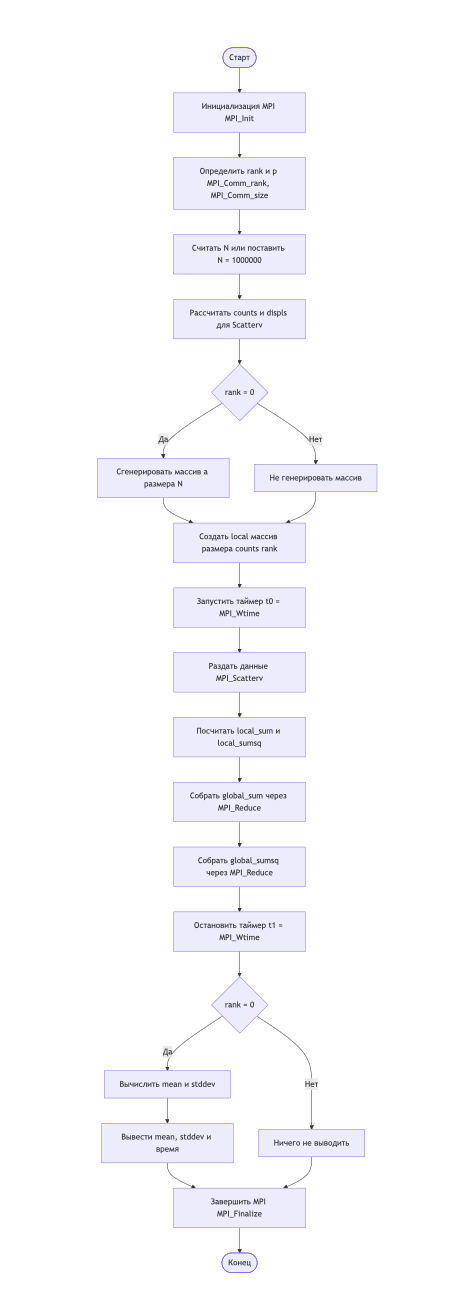

In [1]:
%%writefile task1_stats.cpp
#include <mpi.h>
#include <iostream>
#include <vector>
#include <random>
#include <cmath>
#include <algorithm>

// Функция, которая делает counts/displs для Scatterv
// counts[r] = сколько элементов получит процесс r
// displs[r] = с какого индекса массива начнётся блок для процесса r
static void build_counts_displs(int N, int p, std::vector<int>& counts, std::vector<int>& displs) {
    counts.assign(p, 0);
    displs.assign(p, 0);

    int base = N / p;       // сколько точно получит каждый
    int rem  = N % p;       // остаток (лишние элементы)

    // Первые rem процессов получают на 1 элемент больше
    for (int r = 0; r < p; ++r) {
        counts[r] = base + (r < rem ? 1 : 0);
    }
    // displs — префиксная сумма counts
    for (int r = 1; r < p; ++r) {
        displs[r] = displs[r - 1] + counts[r - 1];
    }
}

int main(int argc, char** argv) {
    MPI_Init(&argc, &argv);

    int rank = 0, p = 1;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &p);

    // Размер массива можно передать аргументом: ./task1 1000000
    int N = 1000000;
    if (argc >= 2) N = std::max(1, std::atoi(argv[1]));

    std::vector<int> counts, displs;
    build_counts_displs(N, p, counts, displs);

    std::vector<double> a;
    if (rank == 0) {
        // Генерация на root, чтобы данные были единые
        a.resize(N);
        std::mt19937 rng(123); // фиксируем seed для воспроизводимости
        std::uniform_real_distribution<double> dist(0.0, 1.0);
        for (int i = 0; i < N; ++i) a[i] = dist(rng);
    }

    // Каждый процесс получает свой кусок
    std::vector<double> local(counts[rank]);

    double t0 = MPI_Wtime();

    MPI_Scatterv(
        rank == 0 ? a.data() : nullptr,
        counts.data(), displs.data(), MPI_DOUBLE,
        local.data(), counts[rank], MPI_DOUBLE,
        0, MPI_COMM_WORLD
    );

    // Локальные суммы
    double local_sum = 0.0;
    double local_sumsq = 0.0;
    for (double x : local) {
        local_sum += x;
        local_sumsq += x * x;
    }

    // Глобальные суммы (на rank=0)
    double global_sum = 0.0;
    double global_sumsq = 0.0;

    MPI_Reduce(&local_sum, &global_sum, 1, MPI_DOUBLE, MPI_SUM, 0, MPI_COMM_WORLD);
    MPI_Reduce(&local_sumsq, &global_sumsq, 1, MPI_DOUBLE, MPI_SUM, 0, MPI_COMM_WORLD);

    double t1 = MPI_Wtime();

    if (rank == 0) {
        // mean = sum/N
        double mean = global_sum / N;

        // stddev = sqrt( (sum(x^2)/N) - mean^2 )
        double var = global_sumsq / N - mean * mean;
        if (var < 0) var = 0; // защита от -0 из-за ошибок округления
        double stddev = std::sqrt(var);

        std::cout << "Task1: N=" << N << " procs=" << p << "\n";
        std::cout << "mean=" << mean << " stddev=" << stddev << "\n";
        std::cout << "Execution time: " << (t1 - t0) << " s\n";
    }

    MPI_Finalize();
    return 0;
}


Writing task1_stats.cpp


In [7]:
!mpic++ task1_stats.cpp -O2 -o task1
!mpirun --allow-run-as-root --oversubscribe -np 4 ./task1 1000000


Task1: N=1000000 procs=4
mean=0.500573 stddev=0.288599
Execution time: 0.00809281 s


Задание 2: Распределённое решение системы линейных уравнений методом
Гаусса
Описание задачи:
Напишите программу для распределённого решения системы линейных
уравнений методом Гаусса:
1. Процесс с "rank = 0" создаёт матрицу коэффициентов A размером NxN и
вектор правых частей b.
2. Разделите строки матрицы между процессами с помощью функции
"MPI_Scatter".
3. Реализуйте следующие шаги метода Гаусса:
- Прямой ход: каждый процесс выполняет вычитание строк для своей части
матрицы.
- Обратный ход: соберите результаты на процессе с "rank = 0" и завершите
вычисления.
4. Выведите решение системы уравнений на экран.
Требования:
- Размеры матрицы должны быть заданы параметрами программы.
- Убедитесь, что программа работает корректно при любом количестве
процессов.
- Используйте "MPI_Bcast" для передачи текущей строки другим процессам во
время прямого хода.

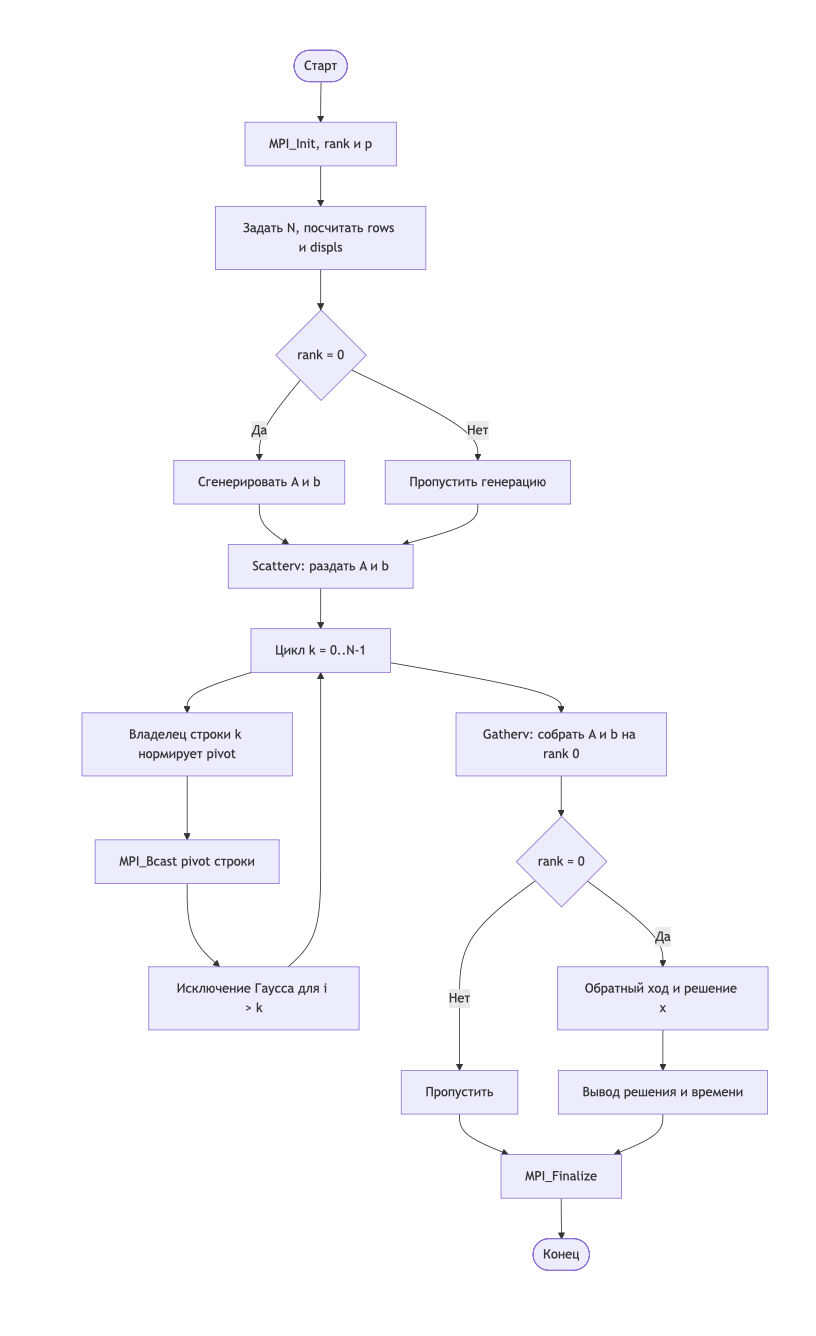

In [3]:
%%writefile task2_gauss.cpp

#include <mpi.h>
#include <iostream>
#include <vector>
#include <random>
#include <cmath>
#include <algorithm>

static void build_counts_displs(int N, int p, std::vector<int>& rows, std::vector<int>& displs) {
    rows.assign(p, 0);
    displs.assign(p, 0);
    int base = N / p;
    int rem  = N % p;
    for (int r = 0; r < p; ++r) rows[r] = base + (r < rem ? 1 : 0);
    for (int r = 1; r < p; ++r) displs[r] = displs[r - 1] + rows[r - 1];
}

static int owner_of_row(int i, const std::vector<int>& displs, const std::vector<int>& rows) {
    // Определяем, какой процесс хранит глобальную строку i
    int p = (int)rows.size();
    for (int r = 0; r < p; ++r) {
        int start = displs[r];
        int end = start + rows[r];
        if (i >= start && i < end) return r;
    }
    return -1;
}

int main(int argc, char** argv) {
    MPI_Init(&argc, &argv);

    int rank = 0, p = 1;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &p);

    int N = 256;
    if (argc >= 2) N = std::max(1, std::atoi(argv[1]));

    std::vector<int> rows, displs;
    build_counts_displs(N, p, rows, displs);
    int local_rows = rows[rank];

    std::vector<double> A, b;

    if (rank == 0) {
        // Я делаю диагональное преобладание, чтобы система была решаемой и устойчивой
        A.resize((size_t)N * N);
        b.resize(N);

        std::mt19937 rng(123);
        std::uniform_real_distribution<double> dist(0.0, 1.0);

        for (int i = 0; i < N; ++i) {
            double rowsum = 0.0;
            for (int j = 0; j < N; ++j) {
                double v = dist(rng);
                A[(size_t)i * N + j] = v;
                rowsum += std::abs(v);
            }
            A[(size_t)i * N + i] += rowsum; // усиливаем диагональ
            b[i] = dist(rng);
        }
    }

    // Счётчики для Scatterv матрицы по строкам
    std::vector<int> sendcntA(p), displA(p);
    for (int r = 0; r < p; ++r) {
        sendcntA[r] = rows[r] * N;
        displA[r]   = displs[r] * N;
    }

    std::vector<double> A_local((size_t)local_rows * N);
    std::vector<double> b_local(local_rows);

    double t0 = MPI_Wtime();

    MPI_Scatterv(rank == 0 ? A.data() : nullptr, sendcntA.data(), displA.data(), MPI_DOUBLE,
                 A_local.data(), sendcntA[rank], MPI_DOUBLE, 0, MPI_COMM_WORLD);

    MPI_Scatterv(rank == 0 ? b.data() : nullptr, rows.data(), displs.data(), MPI_DOUBLE,
                 b_local.data(), local_rows, MPI_DOUBLE, 0, MPI_COMM_WORLD);

    // Pivot-строка + элемент RHS
    std::vector<double> pivot_row(N + 1);

    // Прямой ход
    for (int k = 0; k < N; ++k) {
        int owner = owner_of_row(k, displs, rows);

        // Владелец строки k подготавливает pivot_row
        if (rank == owner) {
            int local_k = k - displs[rank];
            double pivot = A_local[(size_t)local_k * N + k];

            // Нормируем строку
            for (int j = k; j < N; ++j)
                A_local[(size_t)local_k * N + j] /= pivot;

            b_local[local_k] /= pivot;

            for (int j = 0; j < N; ++j)
                pivot_row[j] = A_local[(size_t)local_k * N + j];

            pivot_row[N] = b_local[local_k];
        }

        // Рассылаем pivot_row всем процессам
        MPI_Bcast(pivot_row.data(), N + 1, MPI_DOUBLE, owner, MPI_COMM_WORLD);

        // Вычитание из своих строк i>k
        for (int li = 0; li < local_rows; ++li) {
            int i = displs[rank] + li;
            if (i <= k) continue;

            double factor = A_local[(size_t)li * N + k];
            if (factor == 0.0) continue;

            for (int j = k; j < N; ++j) {
                A_local[(size_t)li * N + j] -= factor * pivot_row[j];
            }
            b_local[li] -= factor * pivot_row[N];
            A_local[(size_t)li * N + k] = 0.0;
        }
    }

    // Собираем обратно на rank=0
    if (rank == 0) {
        A.assign((size_t)N * N, 0.0);
        b.assign(N, 0.0);
    }

    MPI_Gatherv(A_local.data(), sendcntA[rank], MPI_DOUBLE,
                rank == 0 ? A.data() : nullptr, sendcntA.data(), displA.data(), MPI_DOUBLE,
                0, MPI_COMM_WORLD);

    MPI_Gatherv(b_local.data(), local_rows, MPI_DOUBLE,
                rank == 0 ? b.data() : nullptr, rows.data(), displs.data(), MPI_DOUBLE,
                0, MPI_COMM_WORLD);

    // Обратный ход на root
    std::vector<double> x;
    if (rank == 0) {
        x.assign(N, 0.0);
        for (int i = N - 1; i >= 0; --i) {
            double s = b[i];
            for (int j = i + 1; j < N; ++j)
                s -= A[(size_t)i * N + j] * x[j];
            x[i] = s; // диагональ после нормировки ~1
        }
    }

    double t1 = MPI_Wtime();

    if (rank == 0) {
        std::cout << "Task2: N=" << N << " procs=" << p << "\n";
        std::cout << "Example x[0]=" << (N ? x[0] : 0.0) << ", x[N-1]=" << (N ? x[N-1] : 0.0) << "\n";
        std::cout << "Execution time: " << (t1 - t0) << " s\n";
    }

    MPI_Finalize();
    return 0;
}


Writing task2_gauss.cpp


In [8]:
!mpic++ task2_gauss.cpp -O2 -o task2
!mpirun --allow-run-as-root --oversubscribe -np 4 ./task2 256


Task2: N=256 procs=4
Example x[0]=0.00382845, x[N-1]=0.00447167
Execution time: 0.0100916 s


Задание 3: Параллельный анализ графов (поиск кратчайших путей)
Описание задачи:
Напишите программу для параллельного поиска кратчайших путей в графе с
использованием алгоритма Флойда-Уоршелла:
1. Процесс с "rank = 0" создаёт матрицу смежности графа G размером NxN.
2. Разделите строки матрицы между процессами с помощью функции
"MPI_Scatter".
3. Реализуйте алгоритм Флойда-Уоршелла:
- Каждый процесс обновляет свою часть матрицы для текущей итерации.
- Передайте обновлённые данные между процессами с помощью функции
"MPI_Allgather".
4. После завершения всех итераций соберите матрицу на процессе с "rank = 0" и
выведите её на экран.
Требования:
- Размеры графа должны быть заданы параметрами программы.
- Убедитесь, что программа работает корректно при любом количестве
процессов.
- Используйте "MPI_Allgather" для обмена данными между процессами.
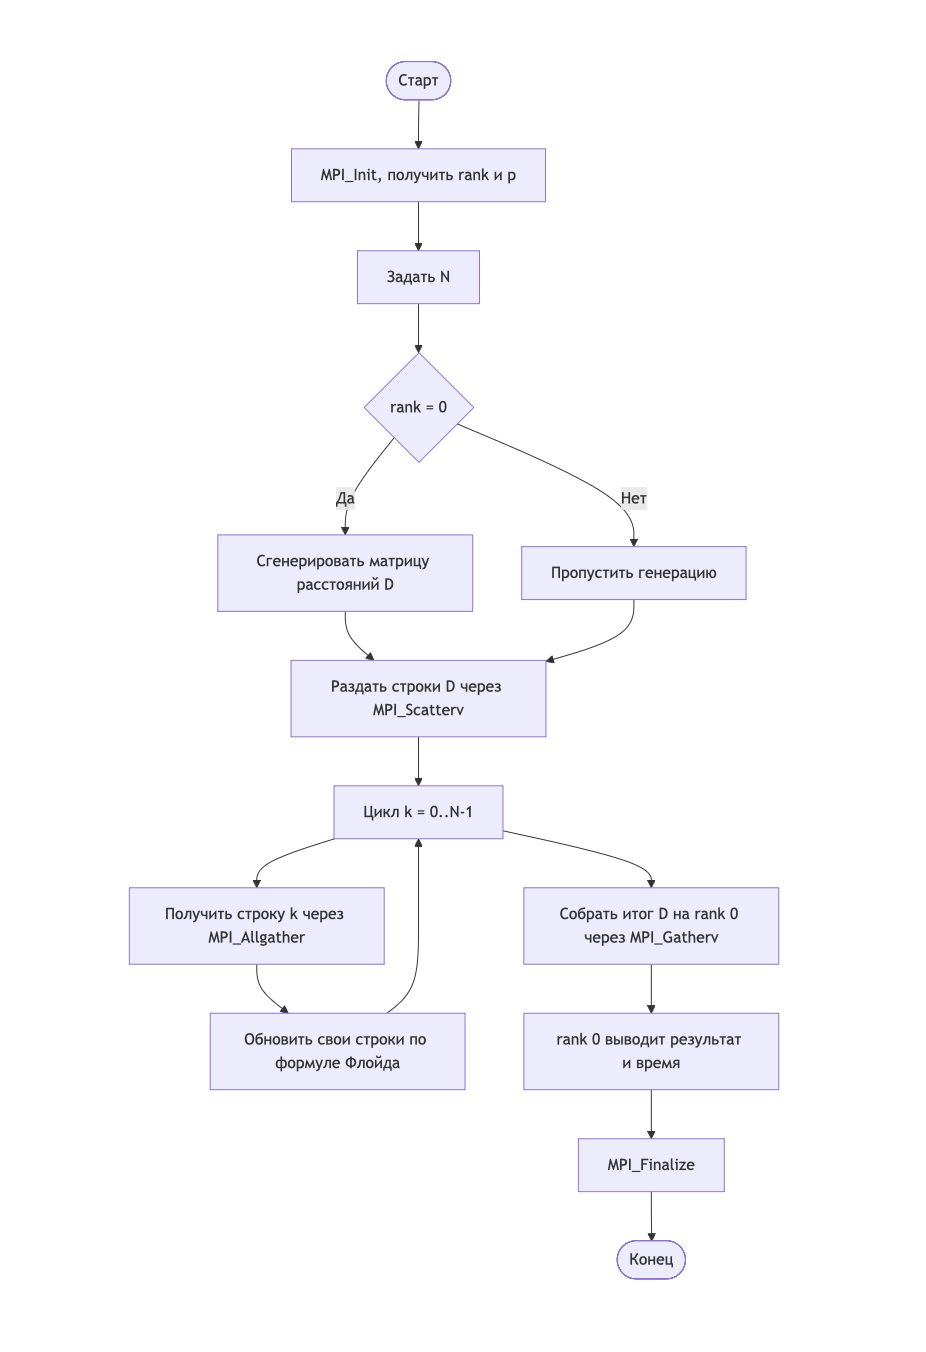


In [10]:
%%writefile task3_floyd.cpp
#include <mpi.h>
#include <iostream>
#include <vector>
#include <random>
#include <algorithm>

static void build_counts_displs(int N, int p, std::vector<int>& rows, std::vector<int>& displs) {
    rows.assign(p, 0);          // инициализируем массив rows нулями
    displs.assign(p, 0);        // инициализируем массив displs нулями

    int base = N / p;           // базовое число строк на каждый процесс
    int rem  = N % p;           // остаток (неравномерность если N не делится на p)

    // распределяем строки: первые rem процессов получают на 1 строку больше
    for (int r = 0; r < p; ++r) rows[r] = base + (r < rem ? 1 : 0);

    // displs строим как префиксную сумму rows
    for (int r = 1; r < p; ++r) displs[r] = displs[r - 1] + rows[r - 1];
}


static int owner_of_row(int i, const std::vector<int>& displs, const std::vector<int>& rows) {
    int p = (int)rows.size();   // количество процессов (rows.size == p)

    // перебираем все процессы и проверяем диапазон строк
    for (int r = 0; r < p; ++r) {
        int start = displs[r];          // первая строка у процесса r
        int end = start + rows[r];      // последняя строка (не включая end)
        if (i >= start && i < end) return r;   // если i в диапазоне, значит владелец найден
    }
    return -1;                  // если не нашли (теоретически не должно быть)
}

int main(int argc, char** argv) {
    MPI_Init(&argc, &argv);     // запускаем MPI (обязательно в начале программы)

    int rank = 0, p = 1;        // rank = номер процесса, p = количество процессов
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);   // узнаём rank текущего процесса
    MPI_Comm_size(MPI_COMM_WORLD, &p);      // узнаём общее количество процессов

    int N = 256;                // размер графа (N вершин => матрица NxN)
    if (argc >= 2) N = std::max(1, std::atoi(argv[1]));  // если передали N, то берём его

    std::vector<int> rows, displs;          // массивы для распределения строк
    build_counts_displs(N, p, rows, displs); // заполняем rows/displs
    int local_rows = rows[rank];            // сколько строк достанется этому процессу

    const int INF = 1000000000;             // большое число = бесконечность (нет ребра)

    std::vector<int> D;                     // полная матрица расстояний (будет только у root)

    if (rank == 0) {                        // только root создаёт весь граф
        D.resize((size_t)N * N);            // память под матрицу NxN

        // Генерация графа: 30% ребер с весом от 1 до 20, иначе INF
        std::mt19937 rng(123);              // генератор случайных чисел с фиксированным seed
        std::uniform_int_distribution<int> wdist(1, 20);       // веса ребра
        std::uniform_real_distribution<double> pdist(0.0, 1.0); // вероятность

        // заполняем матрицу смежности/расстояний
        for (int i = 0; i < N; ++i) {              // по строкам
            for (int j = 0; j < N; ++j) {          // по столбцам
                if (i == j) D[(size_t)i * N + j] = 0;  // расстояние до себя = 0
                else {
                    // если случайное число < 0.30 -> есть ребро
                    // иначе ребра нет -> INF
                    D[(size_t)i * N + j] = (pdist(rng) < 0.30 ? wdist(rng) : INF);
                }
            }
        }
    }

    // Scatterv по строкам: каждому процессу отправим rows[r]*N элементов
    std::vector<int> sendcnt(p), displ(p);     // sendcnt - сколько ints отправляем, displ - смещение
    for (int r = 0; r < p; ++r) {
        sendcnt[r] = rows[r] * N;              // количество элементов (строки * N)
        displ[r]   = displs[r] * N;            // смещение в полном массиве D
    }

    // локальная часть матрицы: local_rows строк, в каждой N чисел
    std::vector<int> D_local((size_t)local_rows * N);

    double t0 = MPI_Wtime();  // старт времени выполнения

    // Раздаём блоки строк матрицы D по процессам
    MPI_Scatterv(rank == 0 ? D.data() : nullptr,   // root отправляет D, остальные nullptr
                 sendcnt.data(), displ.data(), MPI_INT,   // сколько и откуда
                 D_local.data(), sendcnt[rank], MPI_INT,  // куда и сколько получить
                 0, MPI_COMM_WORLD);               // root = 0

    // row_k будет хранить строку k, которая нужна всем процессам
    std::vector<int> row_k(N, INF);

    // sendbuf - буфер для отправки строки k через Allgather
    std::vector<int> sendbuf(N, INF);

    // gathered - сюда Allgather соберёт N элементов от каждого процесса
    std::vector<int> gathered((size_t)p * N, INF);

    // Основной цикл алгоритма Флойда-Уоршелла
    for (int k = 0; k < N; ++k) {                          // k = промежуточная вершина
        int owner = owner_of_row(k, displs, rows);         // определяем, кто владеет строкой k

        // очищаем sendbuf (заполняем INF)
        std::fill(sendbuf.begin(), sendbuf.end(), INF);

        // владелец копирует строку k из D_local в sendbuf
        if (rank == owner) {
            int local_k = k - displs[rank];                // перевод k в локальный индекс
            for (int j = 0; j < N; ++j)
                sendbuf[j] = D_local[(size_t)local_k * N + j]; // копируем строку
        }


        MPI_Allgather(sendbuf.data(), N, MPI_INT,
                      gathered.data(), N, MPI_INT,
                      MPI_COMM_WORLD);


        std::copy(gathered.begin() + (size_t)owner * N,
                  gathered.begin() + (size_t)(owner + 1) * N,
                  row_k.begin());

        // обновляем локальные строки по формуле:
        // D[i][j] = min(D[i][j], D[i][k] + D[k][j])
        for (int li = 0; li < local_rows; ++li) {                // li - локальная строка
            int dik = D_local[(size_t)li * N + k];               // D[i][k] для данной строки
            if (dik >= INF) continue;                            // если пути до k нет, пропускаем

            for (int j = 0; j < N; ++j) {                        // по всем столбцам j
                int dkj = row_k[j];                              // D[k][j] из строки k
                if (dkj >= INF) continue;                        // если пути от k до j нет

                int nd = dik + dkj;                              // новый путь i -> k -> j
                int &cur = D_local[(size_t)li * N + j];          // текущее значение D[i][j]
                if (nd < cur) cur = nd;                          // обновляем если нашли лучше
            }
        }
    }

    // Собираем итоговую матрицу на root
    if (rank == 0) D.assign((size_t)N * N, INF);  // выделяем память на итоговую матрицу

    MPI_Gatherv(D_local.data(), sendcnt[rank], MPI_INT,         // отправляем свои строки
                rank == 0 ? D.data() : nullptr, sendcnt.data(), displ.data(), MPI_INT, // root собирает
                0, MPI_COMM_WORLD);

    double t1 = MPI_Wtime();  // конец измерения времени

    if (rank == 0) {
        std::cout << "Task3: N=" << N << " procs=" << p << "\n"; // параметры эксперимента
        std::cout << "Example: D[0][0]=" << D[0]                 // пример одного элемента
                  << ", D[0][N-1]=" << D[N-1] << "\n";
        std::cout << "Execution time: " << (t1 - t0) << " s\n";  // время выполнения
    }

    MPI_Finalize();    // завершаем MPI (обязательно в конце)
    return 0;          // выход из программы
}


Overwriting task3_floyd.cpp


In [11]:
!mpic++ task3_floyd.cpp -O2 -o task3
!mpirun --allow-run-as-root --oversubscribe -np 4 ./task3 256


Task3: N=256 procs=4
Example: D[0][0]=0, D[0][N-1]=5
Execution time: 0.0226662 s


# Контрольные вопросы:
1. Как изменяется время выполнения программы при увеличении количества
процессов? Почему?

С увеличением числа процессов время обычно уменьшается, потому что вычисления делятся между процессами. Но после определённого момента ускорение становится слабее, так как растут затраты на обмен данными и синхронизацию в MPI (Bcast, Reduce, Allgather).

2. Какие факторы могут влиять на производительность программы?

Влияют объём и частота обмена данными, скорость сети, использование коллективных операций MPI, баланс распределения нагрузки между процессами и дополнительные ожидания из-за синхронизации.

3. Как можно оптимизировать передачу данных между процессами?

Можно уменьшить объём и количество сообщений, передавать только нужные данные, использовать коллективные операции эффективно и применять неблокирующие передачи (MPI_Isend, MPI_Irecv).

4. Какие ограничения возникают при работе с большими данными?

Может не хватить памяти, растёт время коммуникаций, и масштабируемость ухудшается — ускорение перестаёт расти из-за больших затрат на передачу данных.